In [1]:
import sklearn as sk
import numpy as np     
import csv 
import copy 
import random 
import pandas as pd
import pickle
import json  
import openpyxl
import itertools
import pymatgen as mg
import scipy

# Libraries for feature selection
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

# User Defined libraries
import utils_dataset as utilsd

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Tick parameters
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = [
#     r'\usepackage{amsmath}',
#     r'\usepackage{amssymb}']
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['legend.fontsize'] = 15

In [2]:
class inputs:
    def __init__(self,input_type='D10',
                 input_path='/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/Weihs_group_datasets/Jesse_Colab/data/',
                 input_file='DOS_1Jul24.csv',add_target_noise = False):
        self.input_type = input_type
        self.input_path = input_path
        self.input_file = input_file
        self.add_target_noise = add_target_noise
        self.filename   = self.input_path +'/'+ self.input_file
        
    def read_inputs(self):
        print('Reading data for the input dataset type: ', self.input_type)
        
        # Add options for different datasets that we want to read           
        if self.input_type == 'D10':
        	XX, YY, descriptors = self.read_AlAlloys_D10() 
        elif self.input_type == 'D32':
        	XX, YY, descriptors = self.read_AlAlloys_D32()   
        elif self.input_type == 'D43':
        	XX, YY, descriptors = self.read_AlAlloys_D43()             
        return XX, YY, descriptors   
    
    def read_AlAlloys_D10(self):
        '''
        input_type='AlAlloys',
        input_path='/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/Weihs_group_datasets/Jesse_colab/data/',
        input_file='Al_data_1Jul24.csv'
        '''     
        data = pd.read_csv(self.filename)
 
        XX = pd.DataFrame(data, columns=['Volume_Weighted_PSD_Mean','Volume_Weighted_PSD_SD','DOS','UTS','MOT_Full_Curve','MOT_Plastic_Only','Yield_Strength','ETF'])   # 'Normalized_MOT_Full_Curve',
        target = copy.deepcopy(data['D10'].to_numpy())
        YY = target.reshape(-1,1)

        return XX, YY, XX.columns 
    
    def read_AlAlloys_D32(self):
        '''
        input_type='AlAlloys',
        input_path='/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/Weihs_group_datasets/Jesse_colab/data/',
        input_file='Al_data_1Jul24.csv'
        '''     
        data = pd.read_csv(self.filename)
 
        XX = pd.DataFrame(data, columns=['Volume_Weighted_PSD_Mean','Volume_Weighted_PSD_SD','DOS','UTS','MOT_Full_Curve','MOT_Plastic_Only','Yield_Strength','ETF'])   # 'Normalized_MOT_Full_Curve',
        target = copy.deepcopy(data['D32'].to_numpy())
        YY = target.reshape(-1,1)

        return XX, YY, XX.columns 
    
    def read_AlAlloys_D43(self):
        '''
        input_type='AlAlloys',
        input_path='/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/Weihs_group_datasets/Jesse_colab/data/',
        input_file='Al_data_1Jul24.csv'
        '''     
        data = pd.read_csv(self.filename)
 
        XX = pd.DataFrame(data, columns=['Volume_Weighted_PSD_Mean','Volume_Weighted_PSD_SD','DOS','UTS','MOT_Full_Curve','MOT_Plastic_Only','Yield_Strength','ETF'])   # 'Normalized_MOT_Full_Curve',
        target = copy.deepcopy(data['D43'].to_numpy())
        YY = target.reshape(-1,1)

        return XX, YY, XX.columns 
    
    

In [12]:
class feature_selection_algorithms:

    def __init__(self,XX,YY,test_size=0.33,random_state=42):
        
        # Train Data
        # self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(XX, YY, test_size=test_size, random_state=random_state)
        self.X_train = XX
        self.y_train = YY
        
    # LASSO 
    def lasso(self,alpha_range=np.arange(0.001,0.1,0.001)):
        pipeline = Pipeline([('scaler',StandardScaler()),('model',Lasso())])
        search = GridSearchCV(pipeline,{'model__alpha':alpha_range},cv = LeaveOneOut(), scoring="neg_mean_absolute_error")
        search.fit(self.X_train,self.y_train)
        scores = search.cv_results_["mean_test_score"]
        scores_std = search.cv_results_["std_test_score"]

        plt.figure().set_size_inches(8, 6)
        plt.semilogx(alpha_range, scores)
        
        std_error = scores_std / np.sqrt(8)
        
        plt.semilogx(alpha_range, scores + std_error, "b--")
        plt.semilogx(alpha_range, scores - std_error, "b--")
        
        # alpha=0.2 controls the translucency of the fill color
        plt.fill_between(alpha_range, scores + std_error, scores - std_error, alpha=0.2)
        
        plt.ylabel("CV score +/- std error")
        plt.xlabel("alpha")
        plt.axhline(np.max(scores), linestyle="--", color=".5")
        plt.xlim([alpha_range[0], alpha_range[-1]])

        lasso_parameters = search.best_params_
        coefficients = search.best_estimator_.named_steps['model'].coef_
        
        return search, lasso_parameters, coefficients
    
    def compute_lasso(self,descriptors,onlyImportant=True):
    
        #Hardness (0.01,1.0,0.02)
        #Corrosion (0.0001,0.0005,0.0001), 
        
        search, lasso_parameters, coefficients = self.lasso(alpha_range=np.arange(0.0001,0.4,0.001))
        coefficients = search.best_estimator_.named_steps['model'].coef_
        importance = np.abs(coefficients)
        print('Alpha: ',search.best_params_)
        print('Training R2 Error: ',search.best_estimator_.score(self.X_train,self.y_train))
        print('Weights: ', importance)
        print(mean_absolute_error(self.y_train, search.best_estimator_.predict(self.X_train)))
        
        feature_importance_dict = {}
        if onlyImportant:
            dict_keys = descriptors[importance > 0.0]
            dict_values = importance[importance > 0.0]
            for i in range(0,len(dict_keys)):
                feature_importance_dict[dict_keys[i]] = dict_values[i]
        elif not onlyImportant:
            for i in range(0,len(descriptors)):
                feature_importance_dict[descriptors[i]] = importance[i]
        
        importance_df = pd.DataFrame.from_dict(data=feature_importance_dict, orient='index')
        return importance_df
    
    # XGBoost
    def xgboost(self, **kwargs):
        
        # clf = XGBRegressor(n_estimators=100, learning_rate=0.025, max_depth=20, verbosity=0, booster='gbtree', 
        #             reg_alpha=np.exp(-6.788644799030888), reg_lambda=np.exp(-7.450413274554533), 
        #             gamma=np.exp(-5.374463422208394), subsample=0.5, objective= 'reg:squarederror', n_jobs=1)  
        
        clf = XGBRegressor(n_estimators=200, learning_rate=0.025, max_depth=5, verbosity=0, booster='gbtree',
                           reg_alpha=0.001, reg_lambda=0.0006, 
                           gamma=0.0005, subsample=0.5, objective= 'reg:squarederror', n_jobs=1) 
        # clf = XGBRegressor(n_estimators=50, learning_rate=0.01, max_depth=10, verbosity=0, booster='gbtree', 
        #             reg_alpha=0.01, reg_lambda=0.001, 
        #             gamma=0.01, subsample=0.5, objective= 'reg:squarederror', n_jobs=1) 
                           
        paras = clf.get_params()

        clf.fit(self.X_train, self.y_train)        
        return clf
    
    def compute_xgboost(self,X_stand, Y_stand, descriptors, onlyImportant=True):
        
        clf = self.xgboost()
        score = clf.score(fs.X_train, fs.y_train)
        print("Training score: ", score)

        scores = cross_val_score(clf, fs.X_train, fs.y_train,cv=2) #cv=10
        print("Mean cross-validation score: %.2f" % scores.mean())

        ypred = clf.predict(fs.X_test)
        mse = mean_squared_error(fs.y_test, ypred)
        print("MSE: %.2f" % mse)
        print("RMSE: %.2f" % (mse**(1/2.0)))

        f_importance = clf.get_booster().get_score(importance_type='gain')
        feature_importance_dict={}
        
        if onlyImportant:
            for f,value in f_importance.items():
                feature_index = int(f.split('f')[1])
                feature_importance_dict[descriptors[feature_index]] = value
                print(f"Column: {feature_index}, descriptor: {descriptors[feature_index]}")
        
        # XGBoost gives scores only for features that were retained
        # The following peice of code sets the score to 0 for the remaining features
        elif not onlyImportant:  
            num_features = np.linspace(0,len(descriptors)-1,len(descriptors), dtype=int)
            num_features_found = []

            for f,value in f_importance.items():
                feature_index = int(f.split('f')[1])
                num_features_found.append(feature_index)       

            num_features_notFound = np.setdiff1d(num_features,num_features_found).tolist()

            for f in num_features_notFound:
                f_importance['f'+str(f)] = 0.0

            for f in num_features:
                feature_importance_dict[descriptors[f]] = f_importance['f'+str(f)]       
        
        importance_df = pd.DataFrame.from_dict(data=feature_importance_dict, orient='index')
        # importance_df.to_csv('Al_fragmentation_xgboost_D10_oldDescriptors.csv')
        ax = importance_df.plot.bar(logy=False,fontsize=15,legend=False) #,title='XGBoost')
        # ax.set_fontsize(24)
        plt.rcParams.update({'font.size': 20})
        
        ax.set_ylabel('Descriptor Importance')
        # plt.tight_layout()
        # plt.savefig('../bo_output/figures/henry_xgboost.pdf', bbox_inches='tight')

        
        return
    
    # Testing if the input format and computation of pearson correlation coefficients is correct
    def compute_pearson_corr_coeff(self, X_stand, Y_stand, descriptors, onlyImportant=True):
        
        XX_transpose = np.transpose(X_stand)
        rho=[]
        for i in range(0,np.size(x,axis=1)):
            rho_temp = scipy.stats.pearsonr(XX_transpose[i], Y_stand)
            rho.append(rho_temp.pvalue)
        
        feature_importance_dict={}
        
        if onlyImportant:
            for f in range(0,len(descriptors)):
                if rho[f] > 1.e-2:
                    feature_importance_dict[descriptors[f]] = rho[f]  
        if not onlyImportant:
            for f in range(0,len(descriptors)):
                feature_importance_dict[descriptors[f]] = rho[f] 
            
        importance_df = pd.DataFrame.from_dict(data=feature_importance_dict, orient='index')
        
        return importance_df


In [15]:
class plots_class:

    def __init__(self,XX,YY,descriptors):
        self.XX = XX
        self.YY = YY
        self.descriptors = descriptors
        
        
    def plot_PCC_matrix(self,save_plot=False,**kwargs):
        
        if 'tick_list' in kwargs.keys():
            tick_list = kwargs['tick_list']
        else:
            tick_list = strings = [str(num) for num in range(len(self.descriptors))]
            
        X_stand_transpose = np.transpose(self.XX)
        rho_coeff=[]
        pcc = []
        for i in range(len(self.descriptors)):
            for j in range(len(self.descriptors)):
                rho_coeff = scipy.stats.pearsonr(X_stand_transpose[i],X_stand_transpose[j])
                pcc.append(rho_coeff.statistic)

        pcc_matrix = np.array(pcc,dtype=np.float32) 
        pcc_matrix = np.reshape(pcc_matrix,(len(self.descriptors),len(self.descriptors)))

        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
        cax = ax.imshow(pcc_matrix,cmap='RdBu',vmin=-1, vmax=1)
        
        # Add text annotations for each cell
        for i in range(pcc_matrix.shape[0]):
            for j in range(pcc_matrix.shape[1]):
                value = round(pcc_matrix[i, j], 2)
                plt.text(j, i, f'{value:.2f}', ha='center', va='center', color='black', fontsize=10)

        ax.xaxis.set_ticks(list(itertools.chain(range(0,len(self.descriptors)))))
        ax.xaxis.set_ticklabels(tick_list,rotation=90)
        ax.yaxis.set_ticks(list(itertools.chain(range(0,len(self.descriptors)))))
        ax.yaxis.set_ticklabels(tick_list)

        fig.colorbar(cax,label='Correlation Coeff')
        if save_plot:
            plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                        'Weihs_group_datasets/Jesse_Colab/figures/'+kwargs['file_name'],
                        bbox_inches='tight')
            
        return

    def plot_input_features(self,XX,YY,file_name,save_plot=False):
        
        XX['target'] = YY
        columns = list(XX.keys())
        num_columns = len(columns)
        
        # Create a matrix of plots
        fig, axes = plt.subplots(num_columns, num_columns, figsize=(20, 20))

        # Plot each pair of columns against each other
        for i in range(num_columns):
            for j in range(num_columns):
                x_column = XX[columns[i]]
                y_column = XX[columns[j]]

                axes[i, j].plot(y_column, x_column,'o-')
                if i == num_columns-1:
                    axes[i, j].set_xlabel(columns[j])
                if j == 0:
                    axes[i, j].set_ylabel(columns[i])

        # Adjust layout
        plt.tight_layout()
        
        if save_plot:
            plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                        'Weihs_group_datasets/Jesse_Colab/figures/'+
                        file_name,
                        bbox_inches='tight')

        plt.show()
        
        return
        
    def plot_PCC_target(self,save_plot=False,**kwargs):
        
        if 'which_target' in kwargs.keys():
            file_name = kwargs['which_target']+'_pcc.pdf'
            tick_list = kwargs['tick_list']
        else:
            file_name = 'pcc_target.pdf'
            tick_list = strings = [str(num) for num in range(len(self.descriptors))]
            
        X_stand_transpose = np.transpose(self.XX)
        pcc = []
        for i in range(len(self.descriptors)):
            corr_coeff = scipy.stats.pearsonr(X_stand_transpose[i],Y_stand)
            pcc.append(corr_coeff.statistic)
            
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111)
        color = ['black','red','green','orange','blue','limegreen','royalblue']
        ax = sns.barplot(pcc, palette=color)
        ax.xaxis.set_ticklabels(tick_list,rotation=90)
        ax.set(ylabel='Correlation Coefficient')
        ax.set_ylim([-1,1])
        ax.tick_params(direction='in')

        if save_plot:
            plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                        'Weihs_group_datasets/Jesse_Colab/figures/bar_'+file_name,
                        bbox_inches='tight')
        
        fig,ax = plt.subplots(figsize=(7, 4))
        ax.plot(range(len(self.descriptors)),pcc,'o-')
        ax.xaxis.set_ticks(range(len(self.descriptors)))
        ax.xaxis.set_ticklabels(tick_list,rotation=90)
        ax.set_ylim([-1,1])
        plt.xlabel('Feature')
        plt.ylabel('Correlation Coeff')
        ax.tick_params(direction='in')
        
        if save_plot:
            plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                        'Weihs_group_datasets/Jesse_Colab/figures/line_'+file_name,
                        bbox_inches='tight')
        
        plt.show()
        return
    
    def plot_lasso(self,importance_df,save_plot=False,**kwargs):
        
        if 'which_target' in kwargs.keys():
            file_name = kwargs['which_target']+'_lasso.pdf'
            tick_list = kwargs['tick_list']
        else:
            file_name = 'lasso.pdf'
            tick_list = strings = [str(num) for num in range(len(self.descriptors))]
        
        color = ['black','red','green','orange','blue','limegreen','royalblue','black','red','green','orange','blue','limegreen','royalblue']
        color_plot = [color[i] for i in range(len(self.descriptors))]
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111)
        ax.bar(self.descriptors,importance_df[0],color=color_plot)
        ax.set_ylabel('Descriptor Importance')
        plt.xticks(range(len(self.descriptors)),tick_list,rotation=90)
        plt.rcParams.update({'font.size': 20})
        ax.tick_params(direction='in')
        
        # Adjust layout
        plt.tight_layout()
        
        if save_plot:
            plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                        'Weihs_group_datasets/Jesse_Colab/figures/'+
                        file_name,
                        bbox_inches='tight')
            
        plt.show()
        
        return
    
    
    def plot_lasso_mech_properties(self,importance_df,save_plot=False,**kwargs):
        
        if 'which_target' in kwargs.keys():
            file_name = kwargs['which_target']+'_lasso.pdf'
        elif 'file_name' in kwargs.keys():
            file_name = kwargs['file_name']+'_lasso.pdf'        
        else:
            file_name = 'lasso.pdf'

        if 'tick_list' in kwargs.keys():
            tick_list = kwargs['tick_list']        
        else:
            tick_list = [str(num) for num in range(len(self.descriptors))]
            
        color = ['black','red','green','orange','blue','limegreen','royalblue','black','red','green','orange','blue','limegreen','royalblue']
        color_plot = [color[i] for i in range(len(self.descriptors))]
        fig = plt.figure(figsize=(3, 5))
        ax = fig.add_subplot(111)
        ax.bar(self.descriptors,importance_df[0],color=color_plot)
        ax.set_ylabel(kwargs['y_label'])
        plt.xticks(range(len(self.descriptors)),tick_list,rotation=90)
        plt.rcParams.update({'font.size': 20})
        ax.tick_params(direction='in')
        
        # Adjust layout
        plt.tight_layout()
        
        if save_plot:
            plt.savefig('/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/'+
                        'Weihs_group_datasets/Jesse_Colab/figures/'+
                        file_name,
                        bbox_inches='tight')
            
        plt.show()
        
        return
    

Reading data for the input dataset type:  D43


/Users/maitreyeesharma/opt/anaconda3/envs/torch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.448e-03, tolerance: 6.626e-04
  model = cd_fast.enet_coordinate_descent(
/Users/maitreyeesharma/opt/anaconda3/envs/torch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.130e-03, tolerance: 6.905e-04
  model = cd_fast.enet_coordinate_descent(
/Users/maitreyeesharma/opt/anaconda3/envs/torch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, c

Alpha:  {'model__alpha': 0.07110000000000001}
Training R2 Error:  0.9752790775084256
Weights:  [0.36484973 0.         0.         0.15048186 0.67576557 0.
 0.         0.        ]
0.12302589472635761


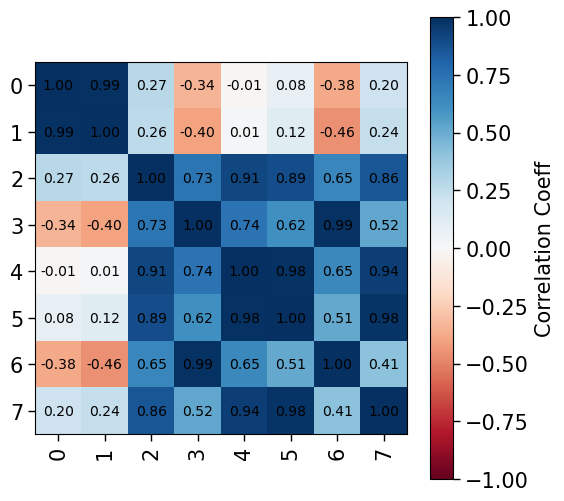

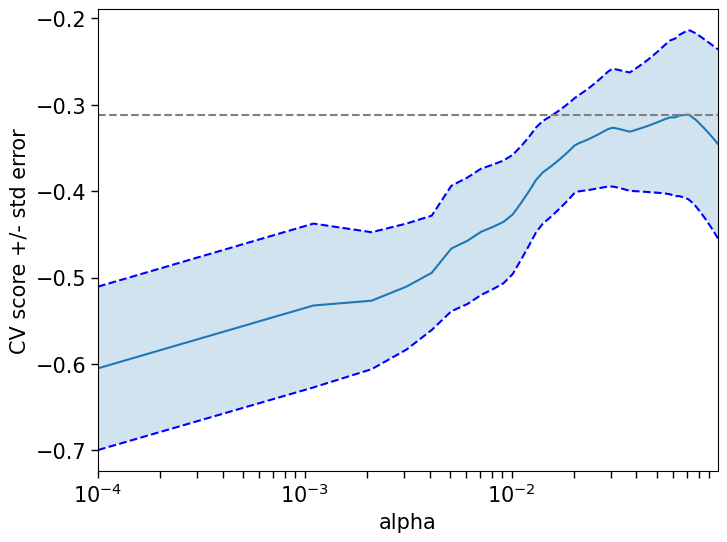

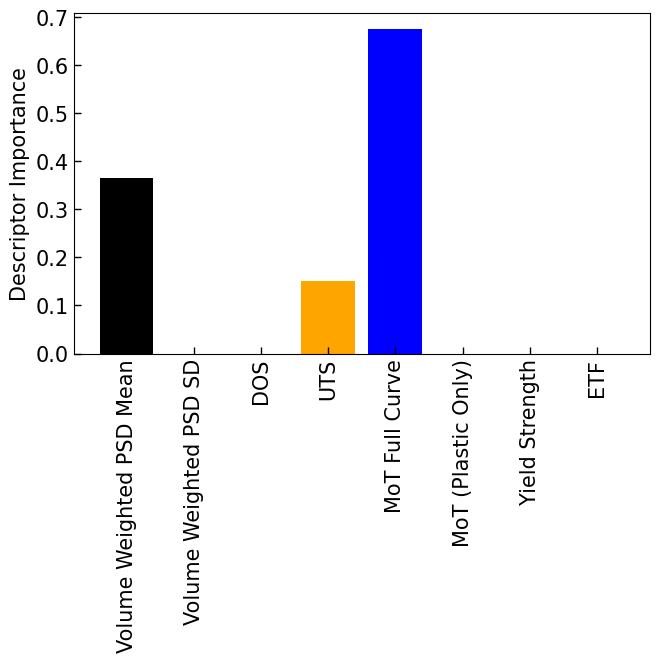

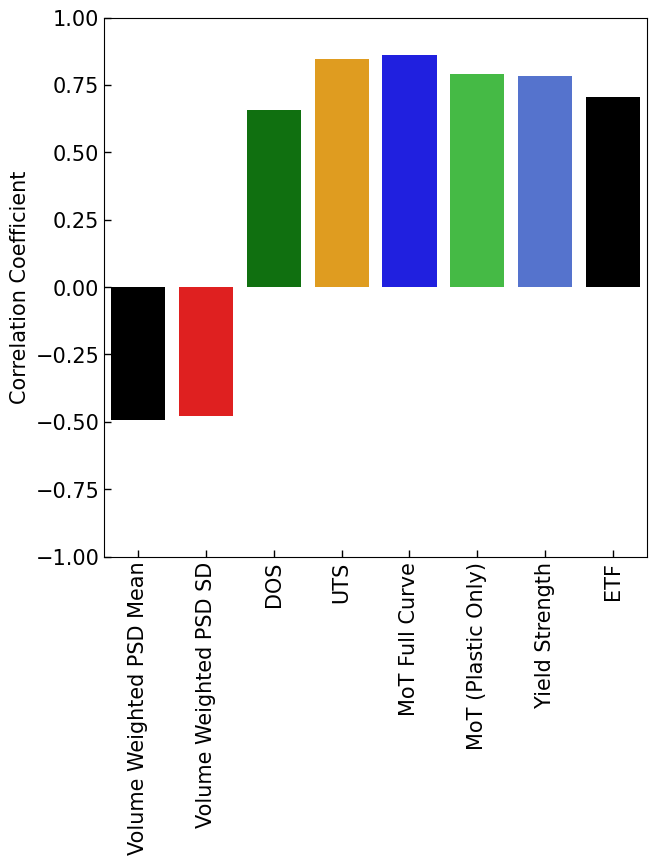

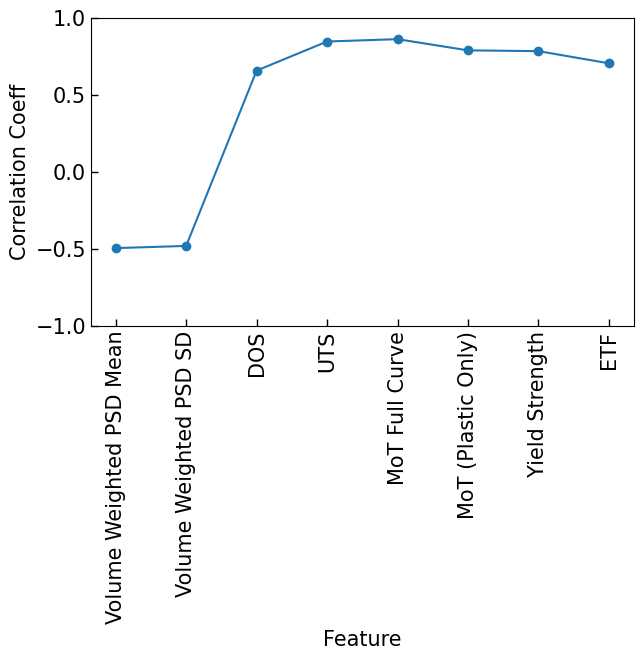

In [5]:
if __name__=="__main__":
    
    run_folder = '/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/Weihs_group_datasets/Jesse_Colab/'
    with open(run_folder+'inputs.json', "r") as f:
        input_dict = json.load(f)
    
    input_type = input_dict['InputType']
    input_path = input_dict['InputPath']
    input_file = input_dict['InputFile']
        
    input = inputs(input_type=input_type,input_path=input_path,input_file=input_file)
    XX, YY, descriptors = input.read_inputs()
    standardize_data = True

    if standardize_data:
        X_stand, scalerX = utilsd.standardize_data(XX)
        Y_stand, scalerY = utilsd.standardize_data(YY)
    else:
        X_stand = XX.to_numpy()
        Y_stand = YY       
    
    # Plots
    plots = plots_class(X_stand,Y_stand,descriptors)
    plots.plot_PCC_matrix(save_plot=False,file_name='microstructure_pcc.pdf')
    # plots.plot_input_features(XX,YY,'input_scatter_hardness_wo_time0.pdf',save_plot=False)
    
    # Feature Selection
    fs = feature_selection_algorithms(X_stand,Y_stand,test_size=0.1,random_state=40)
    
    # LASSO
    importance_df = fs.compute_lasso(descriptors,onlyImportant=False)
    plots.plot_lasso(importance_df, save_plot=False,
                    tick_list=['Volume Weighted PSD Mean','Volume Weighted PSD SD',
                               'DOS','UTS','MoT Full Curve',
                               'MoT (Plastic Only)','Yield Strength','ETF'],
                    which_target=input_type)
    
   
    # PCC
    plots.plot_PCC_target(save_plot=False, tick_list=['Volume Weighted PSD Mean',
                        'Volume Weighted PSD SD','DOS','UTS','MoT Full Curve',
                        'MoT (Plastic Only)', 'Yield Strength','ETF'],
                        which_target=input_type)
    
    # # XGBoost
    # fs.compute_xgboost(X_stand,Y_stand,descriptors,onlyImportant=False)
    
    

Alpha:  {'model__alpha': 0.033100000000000004}
Training R2 Error:  0.8464637020407229
Weights:  [0.53926426 0.84465635]
0.30776280096871744


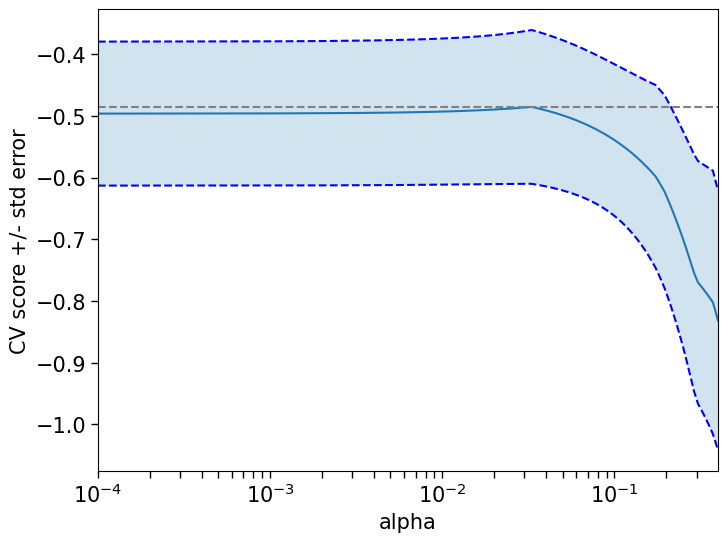

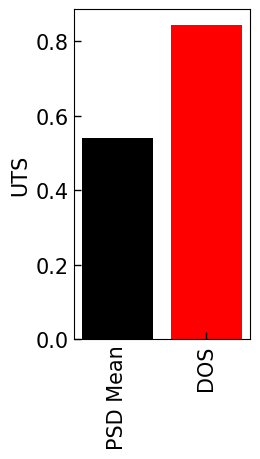

Alpha:  {'model__alpha': 0.0631}
Training R2 Error:  0.8935352803918933
Weights:  [0.19436574 0.90188157]
0.27712197390740795


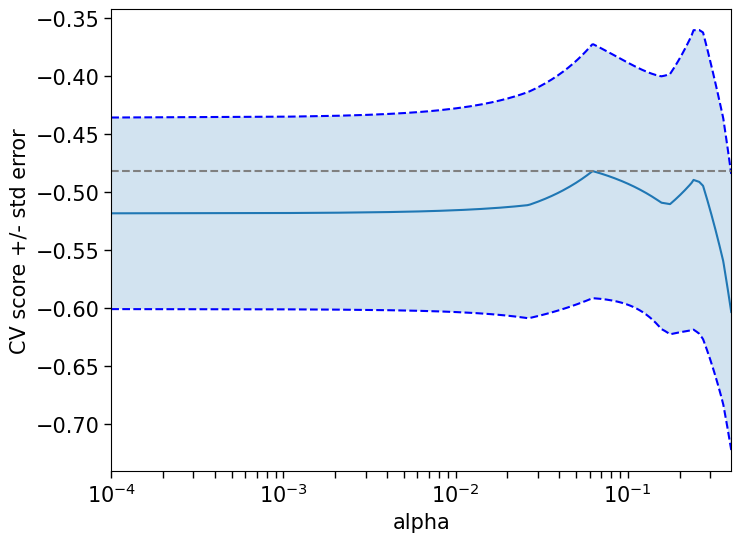

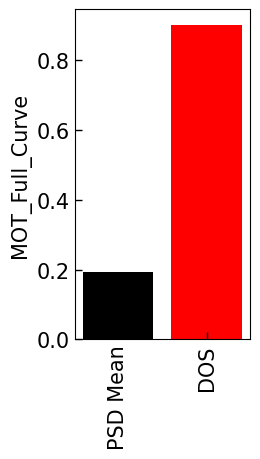

Alpha:  {'model__alpha': 0.2841}
Training R2 Error:  0.7054902656413394
Weights:  [0.         0.60258093]
0.4462613006711453


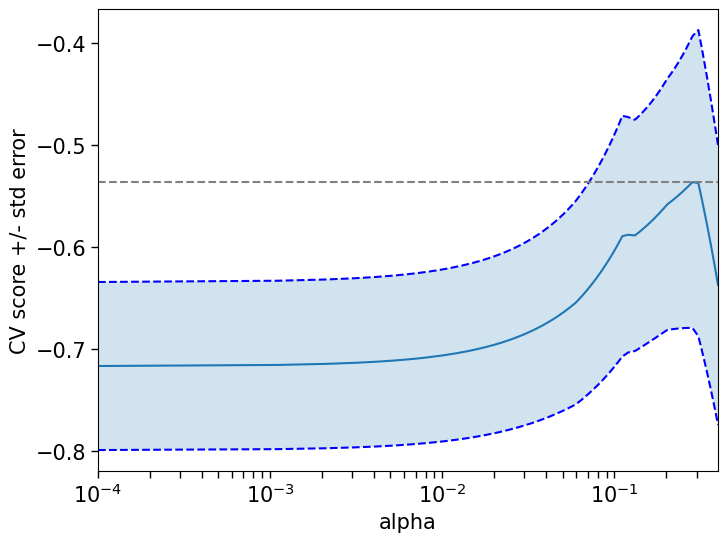

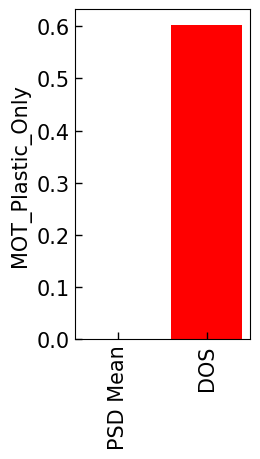

Alpha:  {'model__alpha': 0.0931}
Training R2 Error:  0.7329646757406589
Weights:  [0.47425837 0.68565027]
0.4147879505977719


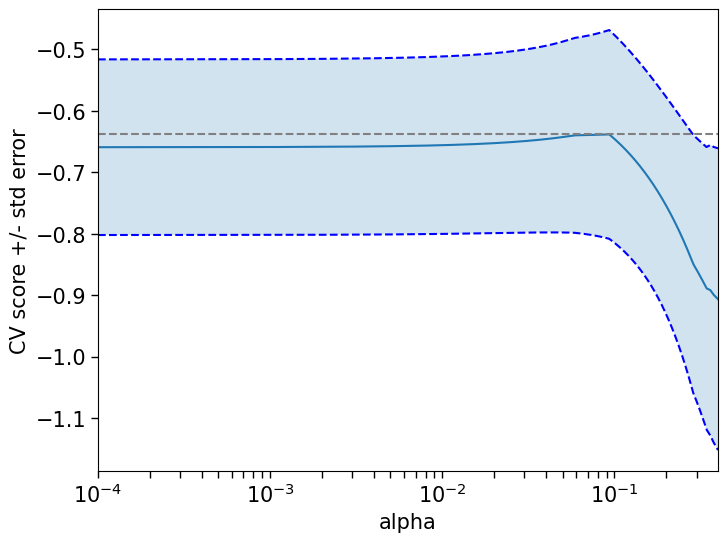

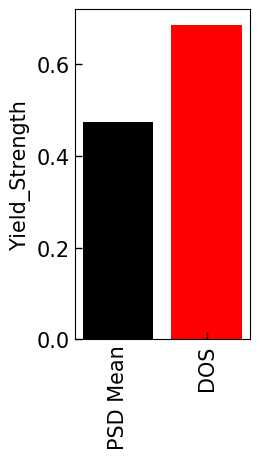

Alpha:  {'model__alpha': 0.2951}
Training R2 Error:  0.6478502068247894
Weights:  [0.         0.56218304]
0.49136578855659657


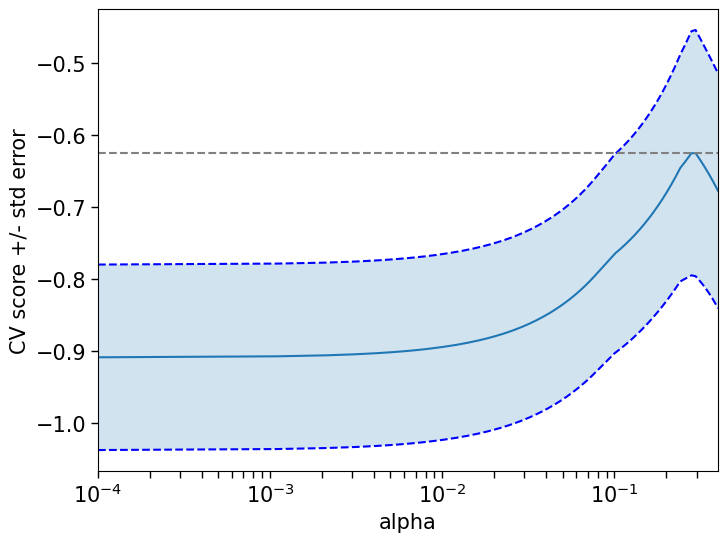

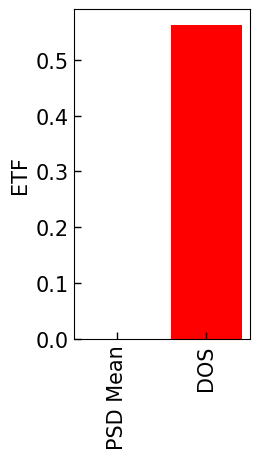

In [18]:
XX_processing = pd.DataFrame(XX, columns=['Volume_Weighted_PSD_Mean','DOS'])
YY_mech = pd.DataFrame(XX, columns=['UTS','MOT_Full_Curve','MOT_Plastic_Only','Yield_Strength','ETF'])  
X_stand_processing, scalerX_processing = utilsd.standardize_data(XX_processing)
descriptors_processing = XX_processing.columns

for mech_prop in YY_mech.keys():
    Y_stand_mech, scalerY_mech = utilsd.standardize_data(YY_mech[mech_prop].to_numpy().reshape(-1, 1))

    # Feature Selection
    fs_processing = feature_selection_algorithms(X_stand_processing,Y_stand_mech,test_size=0.1,random_state=40)
    plots_processing = plots_class(X_stand_processing,Y_stand_mech,descriptors_processing)

    importance_df = fs_processing.compute_lasso(descriptors_processing,onlyImportant=False)
    plots_processing.plot_lasso_mech_properties(importance_df, save_plot=True,
                tick_list=['PSD Mean','DOS'],
                file_name=mech_prop,y_label=mech_prop)
